In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef)

In [2]:
train_df = pd.read_csv('combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,time_to_main_peak,time_to_peak,current_width,tdrift10,tdrift50,tdrift99,tfr,peak_count,gbn,bpr
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2120.0,-635333.796311,...,85,85,0.126727,32.0,65.0,85.0,0.142357,3,1.198436,0.059642
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2004.0,-289756.893085,...,87,87,0.136277,0.0,60.0,87.0,0.151160,3,1.381123,0.061975
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2125.0,-379843.029134,...,95,95,0.236836,35.0,67.0,95.0,0.142606,3,1.361857,0.050813
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2098.0,-252673.626844,...,116,116,0.171464,0.0,90.0,116.0,0.133192,2,1.165654,0.062954
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2037.0,-317761.453582,...,94,94,0.225977,0.0,61.0,94.0,0.145504,7,1.390918,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-240759.341995,...,90,90,0.119532,0.0,55.0,90.0,0.151747,6,1.008092,0.062825
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2045.0,-417622.302428,...,82,82,0.121399,0.0,57.0,79.0,0.150305,3,1.245492,0.062706
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2063.0,-407730.168602,...,102,102,0.168929,0.0,77.0,102.0,0.142950,2,1.149456,0.062153
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,2001.0,-116570.568893,...,92,92,0.122313,0.0,71.0,92.0,0.153135,5,1.192639,0.065264


In [ ]:
label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr",
    "energy_label",
]

feature_cols = [col for col in train_df.columns if col not in label_cols + ['id']]

In [39]:
# Filter rows where ALL of these columns are True
# .all(axis=1) checks if every column in the list is True for that row
matching_rows = train_df[train_df[label_cols].all(axis=1)]
matching_rows

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,time_to_main_peak,time_to_peak,current_width,tdrift10,tdrift50,tdrift99,tfr,peak_count,gbn,bpr
5,5_train_0,202.118818,True,True,True,True,938,3401.0,2016.0,-2.238298e+05,...,86,86,0.121210,0.0,62.0,86.0,0.148161,2,1.333229,0.066141
6,6_train_0,855.765685,True,True,True,True,953,3413.0,2110.0,-9.533368e+05,...,112,112,0.125181,60.0,88.0,106.0,0.136972,1,1.463301,0.061205
8,8_train_0,1212.688940,True,True,True,True,961,3412.0,2089.0,-1.336303e+06,...,113,113,0.117900,65.0,82.0,105.0,0.140185,1,1.217066,0.065910
11,11_train_0,2334.785962,True,True,True,True,961,3412.0,2061.0,-2.494320e+06,...,119,119,0.122090,74.0,92.0,117.0,0.139700,1,1.488288,0.062823
14,14_train_0,2130.987393,True,True,True,True,980,3401.0,2057.0,-2.373392e+06,...,46,46,0.121277,14.0,21.0,43.0,0.157380,1,2.648069,0.072427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039985,1039985_train_15,238.270546,True,True,True,True,966,3401.0,2024.0,-2.676853e+05,...,77,77,0.124577,0.0,26.0,77.0,0.164503,2,1.653406,0.070927
1039986,1039986_train_15,230.961021,True,True,True,True,929,3408.0,2032.0,-2.581743e+05,...,116,116,0.116108,0.0,94.0,116.0,0.138498,1,1.165428,0.069788
1039990,1039990_train_15,299.894902,True,True,True,True,932,3407.0,2021.0,-3.529948e+05,...,119,119,0.114861,36.0,84.0,119.0,0.138221,4,1.135231,0.066935
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-2.407593e+05,...,90,90,0.119532,0.0,55.0,90.0,0.151747,6,1.008092,0.062825


# MODEL TRAINING

## Model Training - psd_label_high_avse

### Baseline Model - Logistic Regression

In [4]:
feature_cols

['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SCA',
 'ND80',
 'current_skewness',
 'tail_slope_no_pz',
 'spectral_centroid_power',
 'current_kurtosis',
 'tail_slope',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'current_width',
 'tdrift10',
 'tdrift50',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr']

In [5]:
pd.concat([train_df["psd_label_high_avse"].value_counts(), 
           train_df["psd_label_high_avse"].value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [6]:
# DATA PREP
X = train_df[feature_cols]
y = train_df["psd_label_high_avse"]

In [17]:
X.isna().sum().sort_values(ascending=False)

PPR                        5
tdrift99                   5
tdrift50                   5
tdrift10                   5
tp0                        0
total_power                0
gbn                        0
peak_count                 0
tfr                        0
current_width              0
time_to_peak               0
time_to_main_peak          0
tail_slope                 0
ED                         0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
LQ80                       0
HWP                        0
bpr                        0
dtype: int64

In [7]:
# SPLIT
# We split first to protect the final test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

In [31]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

# Train
pipe_baseline.fit(X_train, y_train)

# Predict 
y_pred_baseline = pipe_baseline.predict(X_test)

              precision    recall  f1-score   support

       False       0.07      0.88      0.13      1688
        True       1.00      0.91      0.95    206312

    accuracy                           0.91    208000
   macro avg       0.54      0.89      0.54    208000
weighted avg       0.99      0.91      0.94    208000

AUC-PR Score: 0.3199
(Baseline/Random would be: 0.0081)
MCC Score: 0.2365


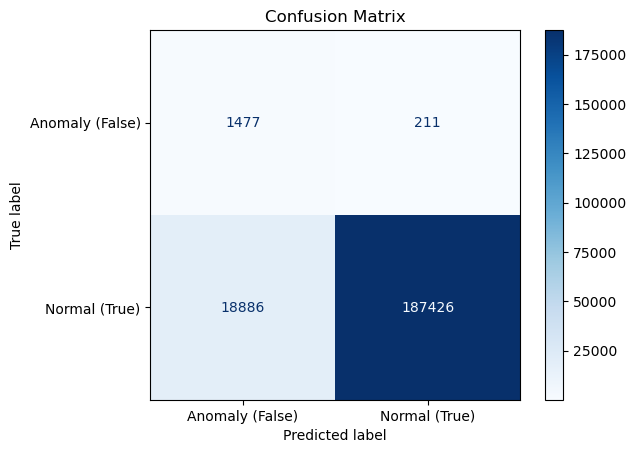

In [32]:
# Evaluate
# main classification metrics
print(classification_report(y_test, y_pred_baseline))

y_test_flipped = (~y_test)
# We need probabilities, not just predictions, for the curve
y_probs = pipe_baseline.predict_proba(X_test)[:, 0] # Prob of class 0 (False/Anomaly)

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred_baseline)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [33]:
# 1. Extract Coefficients and Feature Names
# new_model.coef_[0] holds the weights for the features
coefficients2 = pipe_baseline.named_steps['lr'].coef_[0]

# 2. Create a DataFrame for sorting
feat_imp2 = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients2,
    'Importance': abs(coefficients2) # We sort by the absolute value (magnitude)
})

# 3. Sort by Importance (Highest magnitude at the top)
feat_imp2 = feat_imp2.sort_values(by='Importance', ascending=False)

# Optional: Print the top 5 most influential features
print("\nFeature Importance Ranking")
print(feat_imp2[['Feature', 'Coefficient']])


Feature Importance Ranking
                    Feature  Coefficient
8          tail_slope_no_pz    -5.843269
4                       PPR     3.411397
12              total_power    -3.189715
14             time_to_peak    -2.429578
17                 tdrift50     1.743394
3                      LQ80    -1.438750
7          current_skewness    -1.313143
10         current_kurtosis     1.036535
11               tail_slope     0.895111
22                      bpr    -0.894137
13        time_to_main_peak     0.588095
16                 tdrift10     0.545787
1                        ED    -0.496484
20               peak_count     0.449409
18                 tdrift99     0.425311
9   spectral_centroid_power     0.332467
2                       HWP    -0.297240
19                      tfr    -0.271547
0                       tp0    -0.244617
5                       SCA     0.220009
6                      ND80     0.081331
21                      gbn     0.077810
15            current_width  

In [10]:
# HYPERPARAMETER TUNING (Find the Best Version)
# tune the 'lr' (Logistic Regression) part of the pipe
param_grid = {
    # 'lr__penalty': ['l1', 'l2'],    # Compare "feature selection" (l1) vs "shrinkage" (l2)
    'lr__class_weight': ['balanced', {0:5, 1:1}, {0:10, 1:1}, {0:25, 1:1}, {0:50, 1:1}],
    'lr__C': [0.1, 1, 10]   # Tune regularization strength
}

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'False_F1': make_scorer(f1_score, pos_label=False),
    'True_F1': make_scorer(f1_score, pos_label=True),
    'AUC_PR': make_scorer(average_precision_score, response_method="predict_proba", pos_label=False)
}
scorer = make_scorer(f1_score, pos_label=False)

# Use Standard Stratified K-Fold for speed during the search
grid = GridSearchCV(
    estimator=pipe_baseline,        
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='MCC',
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters...")
grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10],
                         'lr__class_weight': ['balanced', {0: 5, 1: 1},
                                              {0: 10, 1: 1}, {0: 25, 1: 1},
                                              {0: 50, 1: 1}]},
             refit='MCC',
             scoring={'AUC_PR': make_scorer(average_precision_score, response_method='predict_proba', pos_label=False),
                      'False_F1': make_scorer(f1_score, response_method='predict', pos_label=False),
                      'MCC': make_scorer(matthews_corrcoef, response_method='predict'),
                      'True_F1': make_scorer(f1_score, response_method='predict', pos_label=True)},
             verbose=1)

In [11]:
# RESULTS VISUALIZATION
# Convert the results dictionary to a DataFrame
cv_results = grid.cv_results_
results_df = pd.DataFrame(cv_results)

# Filter for the columns we want to see
columns_to_keep = [
    "param_lr__C", 
    "param_lr__class_weight",
    "rank_test_MCC",
    "mean_test_MCC",
    "mean_test_AUC_PR",
    "mean_test_False_F1",
    "mean_test_True_F1",
]

# Create a clean view sorted by best performance
clean_results = results_df[columns_to_keep].sort_values(by="rank_test_MCC")

pd.set_option('display.max_colwidth', None) # Show full param dict

clean_results

,param_lr__C,param_lr__class_weight,rank_test_MCC,mean_test_MCC,mean_test_AUC_PR,mean_test_False_F1,mean_test_True_F1
7,1,"{0: 10, 1: 1}",1,0.436412,0.367457,0.440537,0.995170
12,10,"{0: 10, 1: 1}",2,0.436354,0.367335,0.440473,0.995166
2,0.1,"{0: 10, 1: 1}",3,0.436318,0.367138,0.440515,0.995189
11,10,"{0: 5, 1: 1}",4,0.422450,0.364839,0.419780,0.995959
6,1,"{0: 5, 1: 1}",5,0.422402,0.365094,0.419740,0.995959
1,0.1,"{0: 5, 1: 1}",6,0.421382,0.364750,0.418646,0.995956
3,0.1,"{0: 25, 1: 1}",7,0.377009,0.359762,0.341367,0.989922
8,1,"{0: 25, 1: 1}",8,0.376597,0.359701,0.340742,0.989886
13,10,"{0: 25, 1: 1}",9,0.376317,0.359713,0.340425,0.989874
4,0.1,"{0: 50, 1: 1}",10,0.313665,0.351558,0.232866,0.978931


In [12]:
# Get the best model
best_model = grid.best_estimator_
print(f"Best Params found: {grid.best_params_}")
print(f"Mean MCC: {grid.best_score_}")

# Extract the Logistic Regression step and its coefficients
coefficients = best_model.named_steps['lr'].coef_[0]

# Create df
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Importance': abs(coefficients)
})

# Sort by Absolute Importance (biggest impact at the top)
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# REPORTING (TEXT)
# Use an option context to force Pandas to print the WHOLE list, not just top/bottom
print(f"\n--- FULL FEATURE RANKING: Impact of All {len(feature_importance)} Features on High AVSE ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance[['Feature', 'Coefficient']])

Best Params found: {'lr__C': 1, 'lr__class_weight': {0: 10, 1: 1}}
Mean MCC: 0.4364118399309122

--- FULL FEATURE RANKING: Impact of All 23 Features on High AVSE ---
                    Feature  Coefficient
12              total_power    -3.587620
8          tail_slope_no_pz    -3.222538
3                      LQ80    -1.552198
4                       PPR     1.356265
17                 tdrift50     1.193050
16                 tdrift10     1.160279
14             time_to_peak    -0.865715
7          current_skewness    -0.538128
13        time_to_main_peak     0.444971
18                 tdrift99    -0.347939
11               tail_slope     0.229943
5                       SCA    -0.158488
6                      ND80     0.119162
19                      tfr    -0.106709
15            current_width    -0.098570
22                      bpr    -0.096820
1                        ED    -0.094104
20               peak_count     0.093593
2                       HWP    -0.087847
21            


Final Test Set Performance (20% Hold-out):
              precision    recall  f1-score   support

       False       0.41      0.45      0.43      1688
        True       1.00      0.99      1.00    206312

    accuracy                           0.99    208000
   macro avg       0.71      0.72      0.71    208000
weighted avg       0.99      0.99      0.99    208000

AUC-PR Score: 0.3563
(Baseline/Random would be: 0.0081)
MCC Score: 0.4265


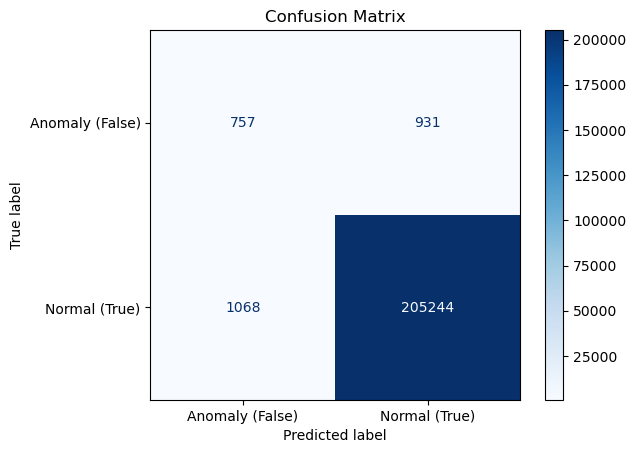

In [13]:
# EVALUATION
print("\nFinal Test Set Performance (20% Hold-out):")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_test_flipped = (~y_test)
# We need probabilities, not just predictions, for the curve
y_probs = best_model.predict_proba(X_test)[:, 0] # Prob of class 0 (False/Anomaly)

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

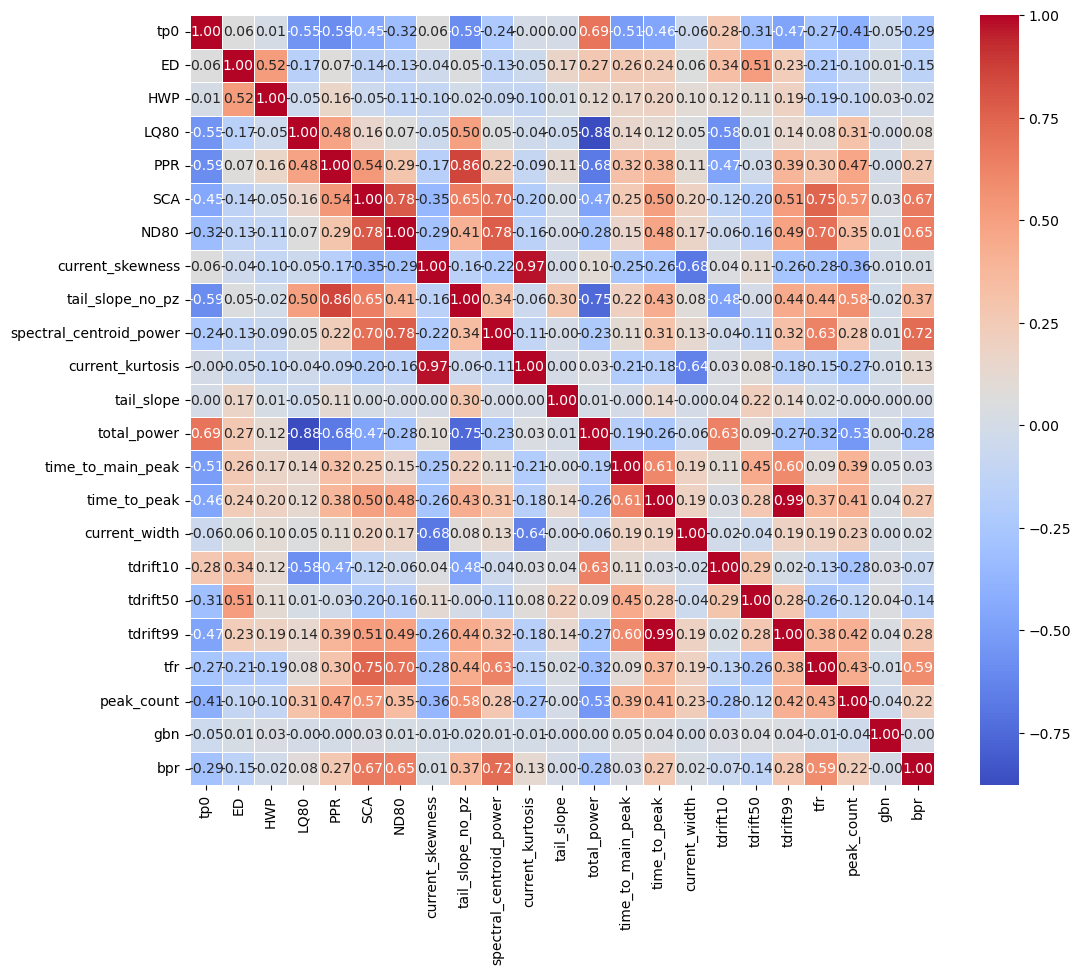

In [14]:
correlation_matrix = pd.DataFrame(X).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm',fmt=".2f", linewidths=.5)
plt.show()


Final Test Set Performance (Dropped: ['time_to_main_peak', 'tdrift99', 'current_kurtosis', 'tail_slope_no_pz', 'SCA']):
              precision    recall  f1-score   support

       False       0.07      0.85      0.13      1688
        True       1.00      0.91      0.95    206312

    accuracy                           0.91    208000
   macro avg       0.53      0.88      0.54    208000
weighted avg       0.99      0.91      0.94    208000

AUC-PR Score: 0.2504
(Baseline/Random would be: 0.0081)
MCC Score: 0.2249


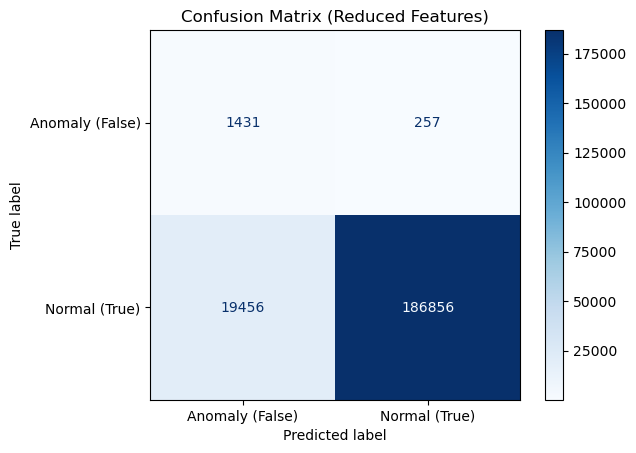

In [36]:
# 1. DROP FEATURES
# Assuming 'X' is your original feature set and 'y' is your target
cols_to_drop = ["time_to_main_peak", "tdrift99", "current_kurtosis", "tail_slope", "SCA"]

# Create the new reduced feature set
drop_least_df = X.drop(columns=cols_to_drop, errors='ignore')

# 2. RE-SPLIT DATA
# We must create new test sets because the features have changed
X_train_new, X_test_new, y_train, y_test = train_test_split(
    drop_least_df, y, test_size=0.2, random_state=42, stratify=y
)

# 3. RE-TRAIN MODEL
# You must initialize and fit a new model on the reduced data
new_model = pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])
new_model.fit(X_train_new, y_train)

# 4. EVALUATION
print(f"\nFinal Test Set Performance (Dropped: {cols_to_drop}):")

# Generate predictions with the NEW model
y_pred = new_model.predict(X_test_new)
print(classification_report(y_test, y_pred))

# Prepare for AUC-PR (Anomaly Detection often treats the Minority/False class as 'Positive' for detection)
# This logic assumes your Normal data is True and Anomalies are False
y_test_flipped = (~y_test) 

# Get probabilities for the class that represents Anomalies (Class 0 / False)
y_probs = new_model.predict_proba(X_test_new)[:, 0] 

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Note: Ensure labels match your boolean logic (False=Anomaly, True=Normal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Reduced Features)")
plt.show()

In [37]:
# 1. Extract Coefficients and Feature Names
# new_model.coef_[0] holds the weights for the features
coefficients = new_model.named_steps['lr'].coef_[0]
feature_names = drop_least_df.columns

# 2. Create a DataFrame for sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients) # We sort by the absolute value (magnitude)
})

# 3. Sort by Importance (Highest magnitude at the top)
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Optional: Print the top 5 most influential features
print("\nFeature Importance Ranking")
print(feat_imp[['Feature', 'Coefficient']])


Feature Importance Ranking
                    Feature  Coefficient
8                tail_slope    -2.764811
13                 tdrift50     1.624019
17                      bpr    -1.522859
10             time_to_peak    -1.329370
12                 tdrift10     1.205095
9               total_power    -0.916482
1                        ED    -0.914101
14                      tfr    -0.458481
0                       tp0    -0.379800
3                      LQ80    -0.331729
6          current_skewness    -0.309300
7   spectral_centroid_power     0.272589
5                      ND80     0.146177
16                      gbn     0.111848
2                       HWP     0.110743
11            current_width     0.097630
4                       PPR     0.082676
15               peak_count    -0.045642
